# Making an MLP Front To Back

In [1]:
import numpy as np
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Setting plot styles
sns.set_style('white')
mpl.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'figure.figsize': (6, 6 / 1.61)
})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4)
})
K = keras.backend

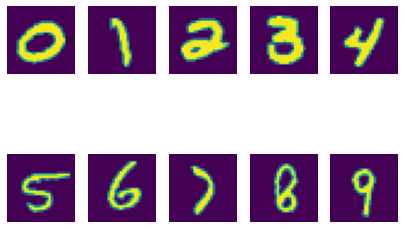

In [20]:
# PLotting each of the ten digits
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_val = X_train[:6000] / 255.
y_val = y_train[:6000]
X_train = X_train[6000:] / 255.
y_train = y_train[6000:]

fig, axes = plt.subplots(2, 5)
axes = axes.ravel()

inds = []
for y in range(10):
    inds.append(np.argmax(y == y_train))
ten_digits = X_train[inds]

for digit, ax in zip(ten_digits, axes):
    ax.grid('off')
    ax.axis('off')
    ax.imshow(digit, cmap='viridis')

In [5]:
def make_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=X_train[0].shape))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [21]:
# Training a simple Keras MLP
K.clear_session()
model = make_model()
model.summary()
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val,  y_val), epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 117,706
Trainable params: 117,706
Non-trainable params: 0
__________________________________________________

In [48]:
# Writing custom training loop
K.clear_session()
train_size = X_train.shape[0]
batch_size = 32
epochs = 10
steps = np.ceil(train_size / batch_size).astype(int)
model = make_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.SGD()
AUTOTUNE = tf.data.experimental.AUTOTUNE
dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(AUTOTUNE)
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
current_loss = 1000

for epoch in range(1, epochs+1):
    pbar = tqdm.tqdm(
        dset,
        position=0,
        leave=True,
        desc=f'Epoch {epoch}/{epochs}:',
        total=steps
        )
    
    for X_batch, y_batch in pbar:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss = loss_fn(y_batch, y_pred)
            
        # finding gradients of loss function w.r.t model weights
        grad = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grad, model.trainable_weights))
        
        display_metrics = {}
        # Computing metrics
        for metric in metrics:
            metric(y_batch, y_pred)
            metric_value = metric.result().numpy()
            display_metrics[metric.name] = metric_value
            
        
        # Adding to the mean loss
        mean_loss(loss)
        loss_value = mean_loss.result().numpy()
        display_metrics['loss'] = loss_value
        pbar.set_postfix(display_metrics)
        
    for metric in metrics:
        metric.reset_states()
        
    mean_loss.reset_states()

Epoch 10/10:: 100%|██████████| 1688/1688 [00:23<00:00, 71.17it/s, accuracy=0.925, loss=0.269]


### Backpropagation
* [U of T Autodiff](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf)
* [AriSeff Autodiff](https://www.youtube.com/watch?v=wG_nF1awSSY)
* [CS231n Backprop](https://cs231n.github.io/optimization-2/)
* [Autodiff In Machine Learning: A Survey](https://arxiv.org/abs/1502.05767)
* [CS229 Backprop](http://cs229.stanford.edu/notes2020spring/cs229-notes-deep_learning.pdf)


In [ ]:
# Implementing Autodiff and backprop
